**Классификатор изображений на основе свёрточной сети LeNet**

Евгений Борисов <esborisov@sevsu.ru>

Backpropagation applied to handwritten zip code recognition.    
LeCun Y., Boser B., Denker J.S., Henderson D., Howard R.E., Hubbard W., Jackel L.D.   
Neural Computation 1989 1(4):541-551.    
http://yann.lecun.com/exdb/publis/pdf/lecun-89e.pdf   

# загружаем данные

In [1]:
from tqdm.auto import tqdm

In [2]:
import torch
import torchvision

# from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST as MNIST
from torch.utils.data import DataLoader

from torchvision import transforms

transform  = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((.5),(.5)) ])
ds_train = MNIST(root='./data', train=True,  download=True, transform=transform)
ds_test  = MNIST(root='./data', train=False, download=True, transform=transform)

target_names = ds_train.classes
n_classes = len(target_names)+1

display(ds_train.data.shape)
display(n_classes)

torch.Size([60000, 28, 28])

11

In [3]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

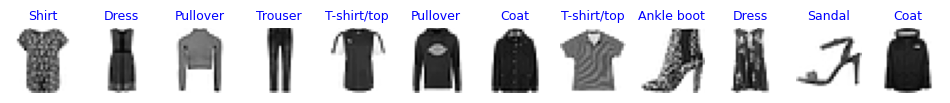

In [4]:
n_show = 12
n_samples = ds_train.data.shape[0]
fig,ax = plt.subplots(1,n_show,figsize=(12,3))
for n,i in enumerate(rng.permutation(n_samples)[:n_show]):
    ax[n].imshow(ds_train.data[i],cmap='gray_r')
    ax[n].set_title(target_names[ ds_train.targets[i]],color='b',fontsize=9)
    ax[n].axis('off')

# модель

In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
from collections import OrderedDict

model = nn.Sequential(OrderedDict([
          ('conv1',  nn.Conv2d(in_channels=1,out_channels=24,kernel_size=3)),
          ('relu1',  nn.ReLU()),
          ('mpool1', nn.MaxPool2d(kernel_size=2) ),
          ('conv2',  nn.Conv2d(in_channels=24,out_channels=64,kernel_size=3)),
          ('relu2',  nn.ReLU()),
          ('flat',   nn.Flatten(start_dim=1) ),
          ('lin1',   nn.Linear(in_features=7744,out_features=n_classes) ),
          ('smax',   nn.Softmax(dim=-1) ),
        ]))

model

Sequential(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1))
  (relu1): ReLU()
  (mpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(24, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (flat): Flatten(start_dim=1, end_dim=-1)
  (lin1): Linear(in_features=7744, out_features=11, bias=True)
  (smax): Softmax(dim=-1)
)

In [7]:
# device = 'cpu'
# with torch.no_grad():
#     for x,target in DataLoader(data_train, batch_size=7, shuffle=False):
#         out = model(x.to(device)).cpu().detach().numpy()
#         break

# display(out.shape)

---

In [12]:
# проверяем GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
display( device )
display( torch.cuda.get_device_name() )

device(type='cuda', index=0)

'Tesla P40'

In [22]:
model = model.to(device)

# criterion =  nn.BCELoss() # ф-ция потери
criterion = nn.CrossEntropyLoss()

# метод оптимизации
optimizer = torch.optim.Adam( model.parameters(), lr=1e-3) 

### обучаем модель

In [23]:
from torch.utils.data import DataLoader

In [24]:
loss_history = [] # значения ф-ции потери
acc_history = []

In [25]:
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score

In [26]:
# x,t = ds_train.data[:3],ds_train.targets[:3],
# x.shape,t.shape

In [28]:
%%time

n_epoch = 16 # количество эпох обучения

for i in tqdm(range(n_epoch)): 
    loss_batch = []

    # получаем батч учебных примеров
    for x,t in DataLoader( ds_train, batch_size=len(ds_train)//5, shuffle=True): 
        o = model.forward(x.to(device)) # считаем выход модели
        loss = criterion( o, t.to(device) ) # вычисляем значение ф-ции потери
        loss_batch.append( loss.item() ) # дополняем историю изменения значений ф-ции потери на батче
        optimizer.zero_grad() # очищаем предыдущее значение градиента
        loss.backward()  # вычисляем текущее значение градиента ф-ции потери
        optimizer.step() # корректируем параметры модели
    
    loss_history.append( np.mean(loss_batch) ) # дополняем общую историю изменения значений ф-ции потери
    
    with torch.set_grad_enabled(False):
        #predicted = model.predict(torch.tensor(x_train,dtype=torch.float32).to(device)).cpu().numpy()
        predicted = model.forward(torch.tensor(x_train,dtype=torch.float32).to(device)).cpu().numpy()
    acc_history.append(accuracy_score(y_true=target_train, y_pred=predicted))
    if acc_history[-1]>.999: break

  0%|          | 0/16 [00:00<?, ?it/s]

NameError: name 'x_train' is not defined

----

In [ ]:
# import torch.optim as optim

In [ ]:
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-4) #, momentum=0.9)

# # from torch.optim.lr_scheduler import ExponentialLR
# # scheduler = ExponentialLR(optimizer, gamma=0.95)

In [ ]:
# # проверяем GPU
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# display( device )
# display( torch.cuda.get_device_name() )

In [ ]:
# # from tqdm.auto import tqdm
# from torch.utils.data import DataLoader

In [ ]:
# %%time

# n_epoch = 32
# history_loss = []
# batch_size = len(data_train)//3

# for epoch in tqdm(range(n_epoch)):  

#     for x,target in DataLoader(data_train, batch_size=batch_size, shuffle=True):
#         optimizer.zero_grad() # zero the parameter gradients
#         loss = criterion( model(x.to(device)), target.to(device) )  # forward 
#         loss.backward() 
#         optimizer.step()
#         history_loss.append( loss.item() )
#     #scheduler.step()

In [ ]:
# # история изменения значений погрешности модели
# fig,ax = plt.subplots(ncols=2,figsize=(11,4))
# ax[0].plot(acc_history,label=f'accuracy (max:{max(acc_history):.3f})',c='r' )
# ax[0].grid()
# ax[0].set_title('accuracy')
# ax[0].legend()
# ax[1].plot(loss_history,label=f'loss (min:{min(loss_history):.3f})',c='b' )
# ax[1].grid()
# ax[1].set_title('loss')
# ax[1].legend()

In [ ]:
# plt.plot(history_loss)
# plt.grid()

## тестируем

### учебный датасет

In [ ]:
from sklearn.metrics import classification_report

images,label,score = [],[],[]

with torch.no_grad():
    for x,target in DataLoader(data_train, batch_size=batch_size, shuffle=False):
        images.append(x.numpy() ) 
        label.append( target.numpy() )
        score.append( model(x.to(device)).cpu().detach().numpy() )

target = np.hstack(label)
predicted = np.argmax(np.vstack(score),axis=1)
print(  classification_report( target,predicted, target_names=target_names, ) )

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(target,predicted), 
        display_labels=target_names,
    )
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

### тестовый датасет

In [ ]:
images,label,score = [],[],[]

with torch.no_grad():
    for x,target in DataLoader(data_test, batch_size=batch_size, shuffle=False):
        images.append(x.numpy() ) 
        label.append( target.numpy() )
        score.append( model(x.to(device)).cpu().detach().numpy() )
np.hstack(label)


target = np.hstack(label)
predicted = np.argmax(np.vstack(score),axis=1)
print(  classification_report( target,predicted, target_names=target_names, ) )

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize=(7,7))
disp = ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(target,predicted), 
        display_labels=target_names,
    )
disp.plot(ax=ax, xticks_rotation='vertical', include_values=True, cmap='viridis',  colorbar=False,)
plt.show()

---

In [ ]:
# !pip3 install watermark

In [ ]:
# !pip3 install watermark
# Python package versions used
%load_ext watermark
%watermark --python
%watermark --iversions
#

In [ ]:
# # размеры входной картинки
# # (h,w),c = data_train.data.shape[1:],1 # размеры входной картинки

# h,w,c = (
#     data_train.data.shape[1:] 
#     if len(data_train.data.shape)==4 
#     else list(data_train.data.shape[1:])+[1]
# )
# display( (h,w,c) )

In [ ]:
# class LeNet(nn.Module):
    
#     def __init__(self,input_size=(h,w,c), n_class= len(target_names)):
#         super().__init__()
        
#         h,w,c = input_size # размеры входной картинки
        
#         (kh,kw),n_maps = (3,3),64 # размер ядра и количество карт признаков
#         self._conv1 = nn.Conv2d( in_channels=c, out_channels=n_maps, kernel_size=(kh,kw))
#         h,w,c = h-((kh//2)*2), w-((kw//2)*2),n_maps # размеры и количество выходных карт признаков
            
#         ph,pw = (2,2) # размер окна для пулинга
#         self._pool1 = nn.MaxPool2d((ph,pw))
#         h,w = h//ph, w//pw # размеры выходных карт признаков
        
#         (kh,kw),n_maps = (3,3),32 # размер ядра и количество карт признаков
#         self._conv2 = nn.Conv2d( in_channels=c, out_channels=n_maps, kernel_size=(kh,kw))
#         h,w,c = h-((kh//2)*2), w-((kw//2)*2),n_maps # размеры и количество выходных карт признаков
        
# #         ph,pw = (2,2) # размер окна для пулинга
# #         self._pool2 = nn.MaxPool2d((ph,pw))
# #         h,w = h//ph, w//pw # размеры выходных карт признаков
        
#         # выходной слой
#         self._fc1 = nn.Linear(in_features=(h*w*c), out_features=n_class)

#     def forward(self, x):
#         o = F.relu(self._conv1(x))
#         o = self._pool1(o)
#         o = F.relu(self._conv2(o))
#         # o = self._pool2(o)
#         o = F.softmax( self._fc1( torch.flatten(o, start_dim=1) ), dim=1 )
#         return o

In [ ]:
# model = LeNet()
# model

In [ ]:
# import torch
# import torchvision
# from torchvision import transforms
# from torchvision.datasets import CIFAR10

# transform  = transforms.Compose([ transforms.ToTensor(), transforms.Normalize((.5),(.5)) ])

# data_train = CIFAR10(root='./data', train=True,  download=True, transform=transform)
# data_test = CIFAR10(root='./data', train=False,  download=True, transform=transform)

# target_names = data_train.classes